<a href="https://colab.research.google.com/github/FennicOculus/gastrointestinal-tract-Polyps/blob/main/Classification_de_polype_gastrique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

the dataset used in this note book can be foud at:  
https://www.kaggle.com/datasets/plhalvorsen/kvasir-v2-a-gastrointestinal-tract-dataset  
https://www.tensorflow.org/tutorials/load_data/images

Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2 as cv
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import pathlib
from tqdm import tqdm
from keras.models import Model
from google.colab.patches import cv2_imshow

Copiying the dataset from Gdrive to session

In [2]:
!cp -r '/content/drive/MyDrive/Kaggle/Polypes Dataset' /content/

In [3]:
path = '/content/Polypes Dataset'

In [4]:
data_dir = tf.keras.utils.image_dataset_from_directory(path)
data_dir = pathlib.Path(path)
print(data_dir)
print(os.path.abspath(data_dir))

Found 8000 files belonging to 8 classes.
/content/Polypes Dataset
/content/Polypes Dataset


In [5]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

8000


In [6]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(8000, reshuffle_each_iteration=False)

In [7]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/Polypes Dataset/esophagitis/194ab026-d45a-489f-936e-dfcf3a347434.jpg'
b'/content/Polypes Dataset/esophagitis/e1d4308b-1fe9-4c50-ac3a-4fa0e38ef487.jpg'
b'/content/Polypes Dataset/dyed-resection-margins/1fb32d40-d263-494a-ac39-e013248b4f2d.jpg'
b'/content/Polypes Dataset/polyps/b6449bbd-27b5-474c-9403-5faf2a2fbfcc.jpg'
b'/content/Polypes Dataset/dyed-resection-margins/2c4f056c-a32d-4351-8010-8df189b9918c.jpg'


In [8]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
class_names

array(['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis',
       'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps',
       'ulcerative-colitis'], dtype='<U22')

In [10]:
val_size = int(8000 * 0.2)
# Total_DS = list_ds.skip(val_size)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
type(train_ds), type(val_ds)

(tensorflow.python.data.ops.dataset_ops.SkipDataset,
 tensorflow.python.data.ops.dataset_ops.TakeDataset)

In [11]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

6400
1600


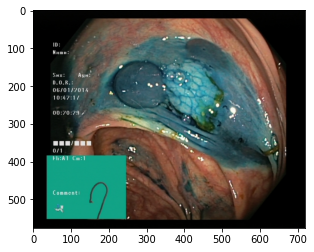

In [12]:
img = cv.imread('/content/Polypes Dataset/dyed-lifted-polyps/007d5aa7-7289-4bad-aa4a-5c3a259e9b19.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

In [13]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [14]:
batch_size = 32
img_height = 100
img_width = 100

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [17]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

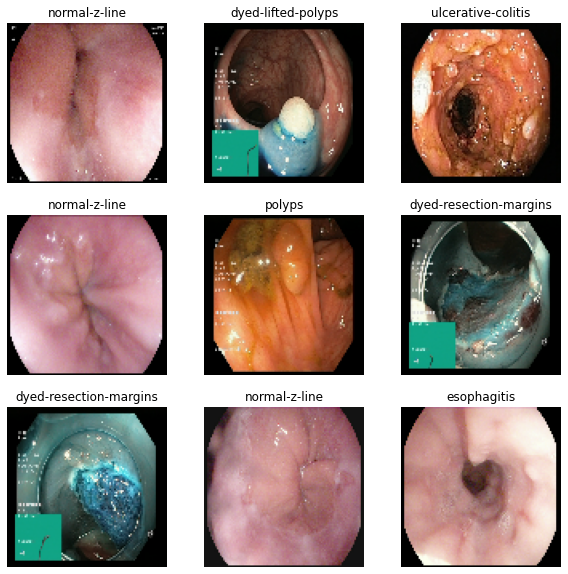

In [18]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [19]:
num_classes = len(class_names)

In [20]:
EnteryLayer = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Resizing(img_height, img_width),
    layers.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    layers.RandomContrast(factor=0.2),
    layers.RandomRotation(0.2),
  ])

In [21]:
model1 = Sequential([
  EnteryLayer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)       

In [24]:
epochs=10
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/2
200/200 [==============================] - 66s 235ms/step - loss: 1.3062 - accuracy: 0.4122 - val_loss: 0.9178 - val_accuracy: 0.5819
Epoch 2/2
200/200 [==============================] - 3s 13ms/step - loss: 0.9298 - accuracy: 0.5525 - val_loss: 0.7916 - val_accuracy: 0.6450


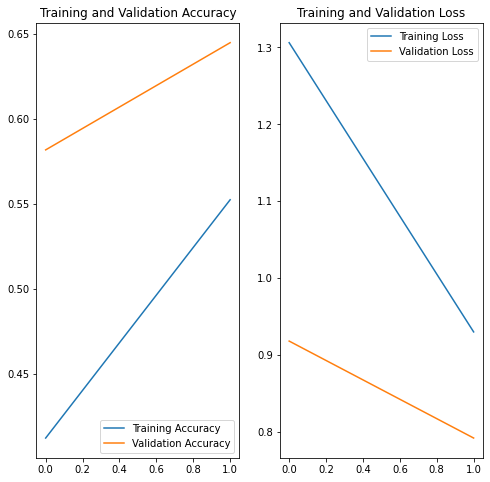

In [25]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
layer_names = [layer.name for layer in model1.layers]
layer_names.pop(0)
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3',
 'dropout',
 'flatten',
 'dense',
 'dense_1',
 'dropout_1',
 'dense_2',
 'dense_3']

In [27]:
layer_outputs = [layer.output for layer in model1.layers]
layer_outputs.pop(0)
layer_outputs

[<KerasTensor: shape=(None, 100, 100, 16) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 50, 50, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 50, 50, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 25, 25, 32) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 25, 25, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 12, 12, 64) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 12, 12, 128) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 6, 6, 128) dtype=float32 (created by layer 'max_pooling2d_3')>,
 <KerasTensor: shape=(None, 6, 6, 128) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 4608) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 128) dtype=float32 

In [28]:
feature_map_model = tf.keras.models.Model(model1.input, layer_outputs)

In [29]:
input = cv.imread('/content/Polypes Dataset/dyed-lifted-polyps/0053d7cd-549c-48cd-b370-b4ad64a8098a.jpg')

In [30]:
from tensorflow.keras.applications import VGG19

In [31]:
VGG19Model = VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(100, 100, 3),
        classes=num_classes,
    )

80150528/80134624 [==============================] - 1s 0us/step


In [32]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  VGG19Model,
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               1179904   
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [35]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/50
200/200 [==============================] - 30s 135ms/step - loss: 1.7223 - accuracy: 0.2744 - val_loss: 1.2346 - val_accuracy: 0.4400
Epoch 2/50
200/200 [==============================] - 28s 140ms/step - loss: 1.0761 - accuracy: 0.4797 - val_loss: 0.8389 - val_accuracy: 0.5612
Epoch 3/50
200/200 [==============================] - 27s 137ms/step - loss: 0.8738 - accuracy: 0.5466 - val_loss: 0.7899 - val_accuracy: 0.5450
Epoch 4/50
200/200 [==============================] - 27s 135ms/step - loss: 0.8701 - accuracy: 0.5517 - val_loss: 0.7952 - val_accuracy: 0.5688
Epoch 5/50
200/200 [==============================] - 28s 138ms/step - loss: 0.7896 - accuracy: 0.5859 - val_loss: 0.7826 - val_accuracy: 0.6000
Epoch 6/50
200/200 [==============================] - 27s 135ms/step - loss: 0.7821 - accuracy: 0.6039 - val_loss: 0.6907 - val_accuracy: 0.6662
Epoch 7/50
200/200 [==============================] - 27s 137ms/step - loss: 0.7675 - accuracy: 0.6202 - val_loss: 0.7692 - val_ac

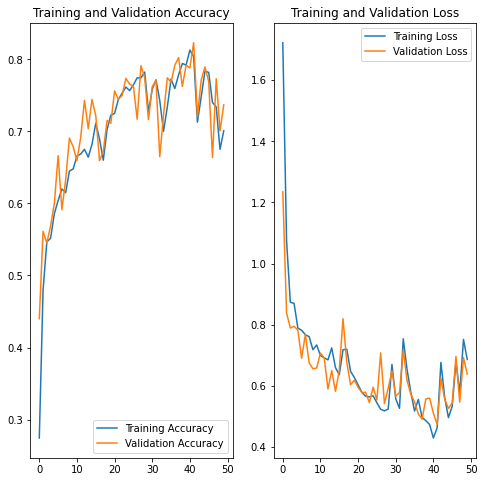

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()